- competition/dataset : [https://www.kaggle.com/c/data-science-bowl-2018](https://www.kaggle.com/c/data-science-bowl-2018)
- date : 2021/03/04
- original : [https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277](https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277)

## Keras U-Net starter - LB 0.277

**✏ 필사 1회** 

### Intro
빠르면서 지저분한 이 커널은 Keras에서 NN을 사용하여 어떻게 핵을 분리해야 하는지에 대해 보여줍니다.  

이 구조는 소위 말하는 [U-Net](https://arxiv.org/abs/1505.04597)으로, 이러한 이미지 분할 문제에서 흔히 사용됩니다. 또한 이것은 작은 데이터 셋에 대해서도 꽤 잘 작동한다고 생각합니다.

In [62]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

In [63]:
# Set some parameter
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'data/stage1_train/'
TEST_PATH = 'data/stage1_test/'

seed = 42
random.seed = seed
np.random.seed = seed

In [64]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

### Get the data
먼저 이미지 전체와 관련된 마스크들을 import합니다. 비교적 가볍고 관리하기 쉽게 트레이닝 이미지와 테스트 이미지 모두 다운샘플링하지만, 예측된 마스크를 업샘플링하고 올바른 RLE를 만들기 위해 테스트 이미지의 원래 크기를 기록해두어야 합니다. 

In [89]:
# Get and resize train images and masks
x_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images masks ...')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    x_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH),
                                      mode='constant', preserve_range=True), axis=-1)
        mask = tf.maximum(mask, mask_)
    y_train[n] = mask

Getting and resizing train images masks ...


  0%|          | 0/670 [00:00<?, ?it/s]

In [90]:
# Get and resize test images
x_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ...')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:, :, :IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    x_test[n] = img

print('Done!')

Getting and resizing test images ...


  0%|          | 0/65 [00:00<?, ?it/s]

Done!


임의의 이미지와 마스크를 그려보고 문제가 없는지 살펴봅시다.

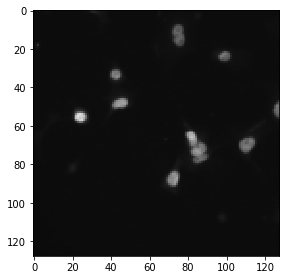

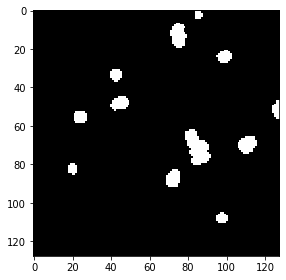

In [91]:
# Check if training data loos all right
ix = random.randint(0, len(train_ids))
imshow(x_train[ix])
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()

### Create our Keras metric
Keras에서 다른 IoU (교집합 영역/합집합 영역) 임계값 메트릭에 대한 평균 정밀도를 정의해보겠습니다. Tensorflow에 평균 IoU 메트릭이 있지만 다중 임계값의 평균에 대한 지원은 없으므로 아래 코드를 통해 실행해볼 것입니다. 그러나 이 구현이 정확한지에 대해서는 확신할 수 없습니다.  

-> 이 구현은 여기 내용과 LB 결과 간의 큰 불일치로 인해 정확하지 않은 것 같습니다. 또한 훈련시킬 때 이것이 점점 증가하는 것으로 보입니다.

In [92]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.cast(y_pred > t, tf.int32)
#         y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.keras.metrics.MeanIoU(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

### Built and train our neural network
[U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf)을 기반으로 [이 레포](https://github.com/jocicmarko/ultrasound-nerve-segmentation)와 유사한 U-Net 모델을 구축해보겠습니다.

![U-Net](data/u-net-architecture.png)

In [93]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x/255)(inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2)(c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2))(c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2)(c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D((2, 2))(c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.1)(c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 128, 128, 3)  0           input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_190 (Conv2D)             (None, 128, 128, 16) 448         lambda_10[0][0]                  
__________________________________________________________________________________________________
dropout_90 (Dropout)            (None, 128, 128, 16) 0           conv2d_190[0][0]                 
______________________________________________________________________________________

다음은 0.1의 검증 분할을 사용하여 트레이닝 데이터에 모델을 학습시킵니다. 우리 데이터는 매우 작기 때문에 작은 배치 사이즈를 사용합니다. 체크포인트를 사용하고 모델이 학습되면 조기종료하는 것을 추천합니다.

In [94]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('data/model-dsbowl2021-1.h5', verbose=1, save_best_only=True)
results = model.fit(x_train, y_train, validation_split=0.1, batch_size=16,
                    epochs=50, callbacks=[earlystopper, checkpointer])

Epoch 1/50


OperatorNotAllowedInGraphError: in user code:

    C:\Users\PC\anaconda3\envs\kaggle\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    <ipython-input-92-c1e1c0b77081>:7 mean_iou  *
        score, up_opt = tf.keras.metrics.MeanIoU(y_true, y_pred_, 2)
    C:\Users\PC\anaconda3\envs\kaggle\lib\site-packages\tensorflow\python\keras\metrics.py:2765 __init__  **
        super(MeanIoU, self).__init__(name=name, dtype=dtype)
    C:\Users\PC\anaconda3\envs\kaggle\lib\site-packages\tensorflow\python\keras\metrics.py:154 __init__
        super(Metric, self).__init__(name=name, dtype=dtype, **kwargs)
    C:\Users\PC\anaconda3\envs\kaggle\lib\site-packages\tensorflow\python\training\tracking\base.py:457 _method_wrapper
        result = method(self, *args, **kwargs)
    C:\Users\PC\anaconda3\envs\kaggle\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:343 __init__
        self._init_set_name(name)
    C:\Users\PC\anaconda3\envs\kaggle\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:2410 _init_set_name
        if not name:
    C:\Users\PC\anaconda3\envs\kaggle\lib\site-packages\tensorflow\python\framework\ops.py:877 __bool__
        self._disallow_bool_casting()
    C:\Users\PC\anaconda3\envs\kaggle\lib\site-packages\tensorflow\python\framework\ops.py:487 _disallow_bool_casting
        "using a `tf.Tensor` as a Python `bool`")
    C:\Users\PC\anaconda3\envs\kaggle\lib\site-packages\tensorflow\python\framework\ops.py:474 _disallow_when_autograph_enabled
        " indicate you are trying to use an unsupported feature.".format(task))

    OperatorNotAllowedInGraphError: using a `tf.Tensor` as a Python `bool` is not allowed: AutoGraph did convert this function. This might indicate you are trying to use an unsupported feature.


### Make predictions
테스트 셋과 검증 셋, 트레이닝 셋에 대해 예측 결과를 만들어 봅시다. 조기 종료나 체크포인트를 사용한 경우 가장 잘 저장된 모델을 불러와야 합니다.

In [ ]:
# Predict on train, val and test
model = load_model('data/model-dsbowl2021-1.h5', custom_objects={'mean_iou':mean_iou})
preds_train = model.predict(x_train[:int(x_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(x_train[int(x_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(x_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]),
                                       (sizes_test[i][0], sizes_test[i][1]),
                                       mode='constant', preserve_range=True))

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(x_train[ix])
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

In [ ]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(x_train[int(x_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

### Encoded and submit our results

In [ ]:
# Run-length encoding
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1):
            run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [ ]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prop_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [ ]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('data/submission_2_sub-dsbowl2021-1.csv', index=False)